## Images Study

### Objectives
* Answere business requirements:

    - The Client wants to be able to visually differentiate between cherry leaves with and without powdery mildew.

## Inputs
* Train, validation and test datasets.

## Outputs
* The code to generate an images montage.
* Mean and varibility of images for each label.
* Plot with contrast between mean images.
* Pixel values variability analys for whole images.
    - RGB variability within each image per label
* Pixel values variability analysis for centers of images.
    - RGB variability within each image per label

---

## Install libraries.

In [37]:
%pip install -r /workspace/pp5mildew/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 7.5 MB/s eta 0:00:00:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.0
    Uninstalling joblib-1.4.0:
      Successfully uninstalled joblib-1.4.0
Note: you may need to restart the kernel to use updated packages.


---

### Change working directory
Change working directory to project root directory.

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/pp5mildew/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))


current_dir = os.getcwd()
current_dir

'/workspace/pp5mildew'

___

## Set up directories and variables.

### Store file paths.

input directories.

In [4]:
data_dir = "inputs/datasets/cherry-leaves"

train_dir = data_dir + "/train"
val_dir = data_dir + "/val"
test_dir = data_dir + "/test"

### Create outputs directory.

In [5]:
# Set version here
version = "v1"

file_path = f"outputs/{version}"

if "outputs" in os.listdir(current_dir) and version in os.listdir(current_dir + "/outputs"):
    print("This version tag has already been used. Create a new version.")
    pass
else:
    os.makedirs(name=file_path)

#### Store label names.

In [6]:
labels = os.listdir(train_dir)
print("The images labels are:", labels)

The images labels are: ['healthy', 'powdery_mildew']


---

### Import libraries.

In [7]:
import itertools
import random
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

sns.set_style("white")

---

### Images setupts.

In [8]:
# Function is taken from CI walktrough project
def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    if the label exists in the directory
    check if your desired montage space is greater than the label subset size
    create a list of axes indices based on nrows and ncols
    create a Figure and display images
    in this loop, load and plot the given image
    """

    labels = os.listdir(dir_path)

    # subset the class you are interested to display
    if label_to_display in labels:

        # checks if your desired montage space is greater than the label subset size
        images_list = os.listdir(dir_path + "/" + label_to_display)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces"
            )
            return

        # create a list of axes indices based on nrows and ncols
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # create a Figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows * ncols):
            img = imread(dir_path + "/" + label_to_display + "/" + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px"
            )
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")

Create a montages for each label.

healthy


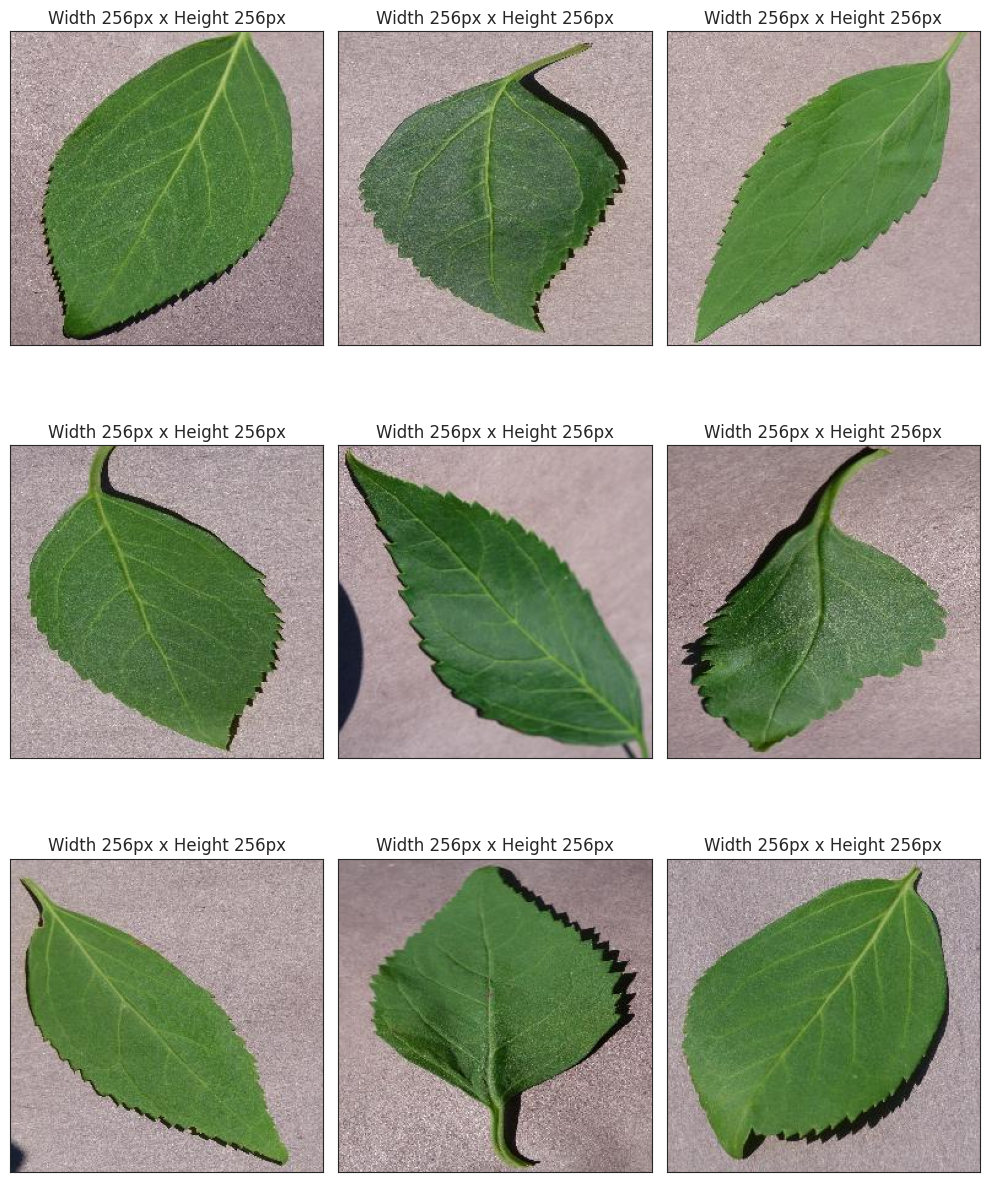



powdery_mildew


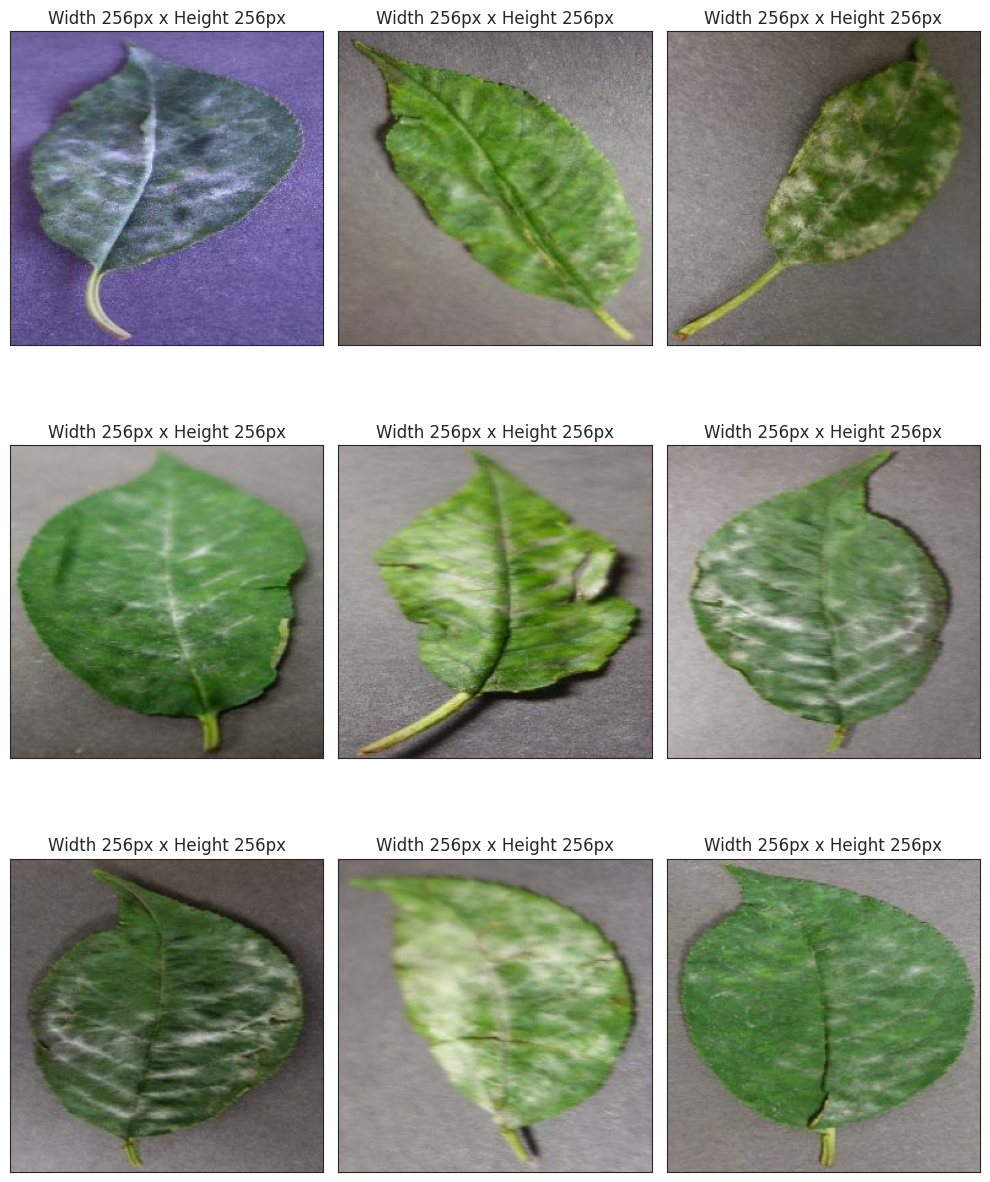

In [9]:
for label in labels:
    print(label)
    image_montage(
        dir_path=train_dir, label_to_display=label, nrows=3, ncols=3, figsize=(10, 13)
    )
    print("\n")

__Note:__ visually, it appears as if there are qualitative differences between the two classes beyond the precense or absence of powdery mildew.
* After viewing a few random samples, all powdery mildew leaf images have the leaf pointing toward the top, whereas healthy leaves point either up or down.
* It appears as if the backdrop of the two groups of images have a slightly different color and/or texture.

This could lead to potentially limited model performance, if it picks up patterns that are not inherent to the presencse of the mildew. Investigate this further in the following mean and variability plots.

---

### Load a subset of images

Only a subset of images will be used for the images studies, to save time.

create a function to load imes as Numpy arrays.

In [10]:
from tensorflow.keras.preprocessing import image

# Function is from CI Walktrough.
def load_images_as_arrays(data_dir, n_images_per_label=20):
    """Load passed number of images for each label as np arrays and normalize the color values"""

    X, y = np.array([], dtype="int"), np.array([], dtype="object")
    labels = os.listdir(data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(data_dir + "/" + label):
            if counter < n_images_per_label:

                img = image.load_img(
                    data_dir + "/" + label + "/" + image_filename,
                )

                # if pixel values use 0 to 255 scale, normalize to 0 to 1 scale
                if image.img_to_array(img).max() > 1:
                    img_processed = image.img_to_array(img) / 255
                else:
                    img_processed = image.img_to_array(img)

                X = np.append(X, img_processed).reshape(
                    -1, img_processed.shape[0], img_processed.shape[1], img_processed.shape[2]
                )
                y = np.append(y, label)
                counter += 1

    return X, y

Load 100 images for each label as array.

In [11]:
images_arr, labels_arr = load_images_as_arrays(
    data_dir=train_dir, n_images_per_label=100
)

### Create helper function.

In [12]:
def subset_label(label_to_display, X, y):
    """Return subset of X where y is label_to_display"""
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    return X[boolean_mask]

---

## Image averages and variability

Create a function to plot the deviation of each set of images.

In [13]:
# Function taken from CI walktrough.

def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        arr = subset_label(label_to_display, X, y)

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f'Average image for label "{label_to_display}"')
        axes[0].imshow(avg_img, cmap="gray")
        axes[1].set_title(f'Variability image for label "{label_to_display}"')
        axes[1].imshow(std_img, cmap="gray")

        if save_image:
            plt.savefig(
                f"{file_path}/avg_var_{label_to_display}.png",
                bbox_inches="tight",
                dpi=150,
            )
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

plot the means and standard deviations of the images set for the loaded images above.

==== Label healthy ====


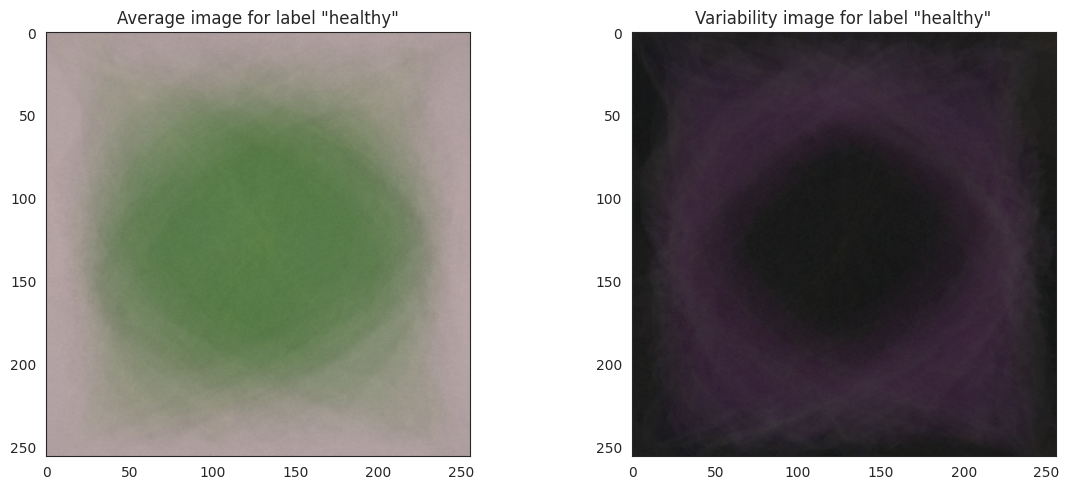



==== Label powdery_mildew ====


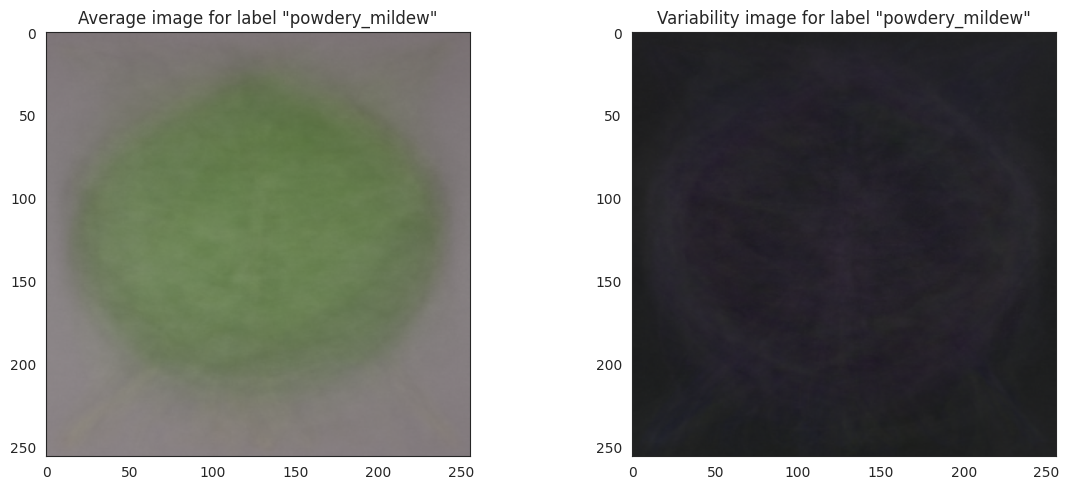

In [14]:
plot_mean_variability_per_labels(X=images_arr, y=labels_arr, figsize=(12, 5))

After checking that the images is good, save it to the outputs folder.

==== Label healthy ====
==== Label powdery_mildew ====


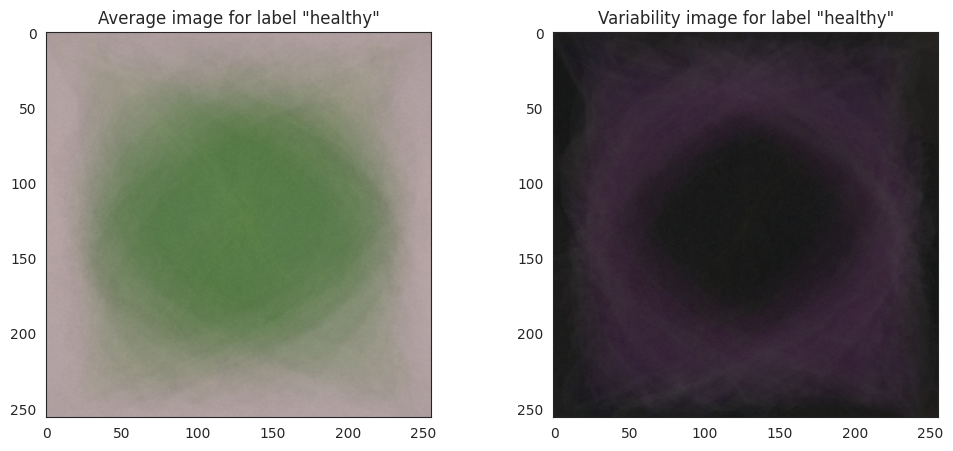

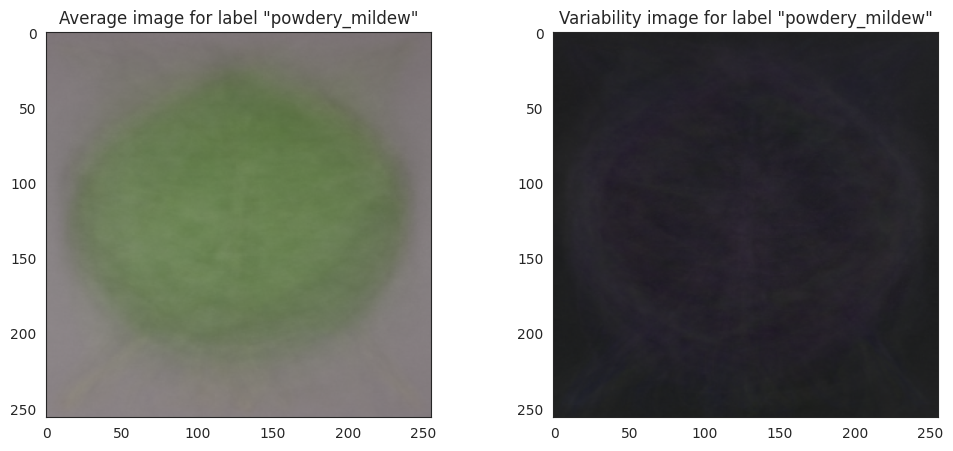

In [15]:
plot_mean_variability_per_labels(X=images_arr, y=labels_arr, figsize=(12, 5), save_image=True)

### Show difference between average images

In [16]:
# Function is from CI walktrough proejct.

def diff_bet_avg_image_labels_data_as_array(
    X, y, label_1, label_2, figsize=(20, 5), save_image=False
):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and saves it if save_image=True
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
        return

    # calculate mean from label1
    images_label1 = subset_label(label_1, X, y)
    label1_avg = np.mean(images_label1, axis=0)

    # calculate mean from label2
    images_label2 = subset_label(label_2, X, y)
    label2_avg = np.mean(images_label2, axis=0)

    # calculate difference and plot difference, avg label1 and avg label2
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap="gray")
    axes[0].set_title(f"Average {label_1}")
    axes[1].imshow(label2_avg, cmap="gray")
    axes[1].set_title(f"Average {label_2}")
    axes[2].imshow(difference_mean, cmap="gray")
    axes[2].set_title(f"Difference image: Avg {label_1} & {label_2}")
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches="tight", dpi=150)
    else:
        plt.tight_layout()
        plt.show()

Show the different between powdery mildew average and healthy avarage.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


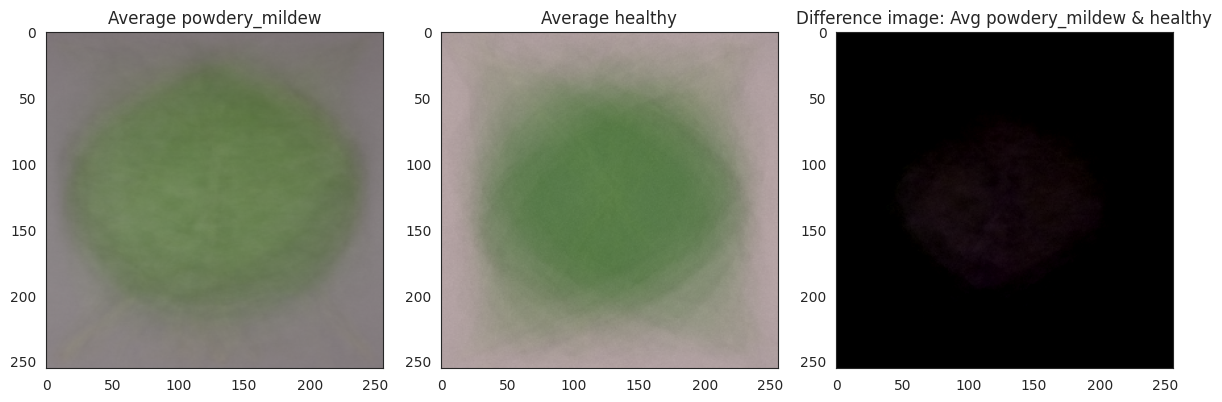

In [17]:
difference = diff_bet_avg_image_labels_data_as_array(
    X=images_arr,
    y=labels_arr,
    label_1="powdery_mildew",
    label_2="healthy",
    figsize=(12, 10),
)

plot the different from the otherway.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


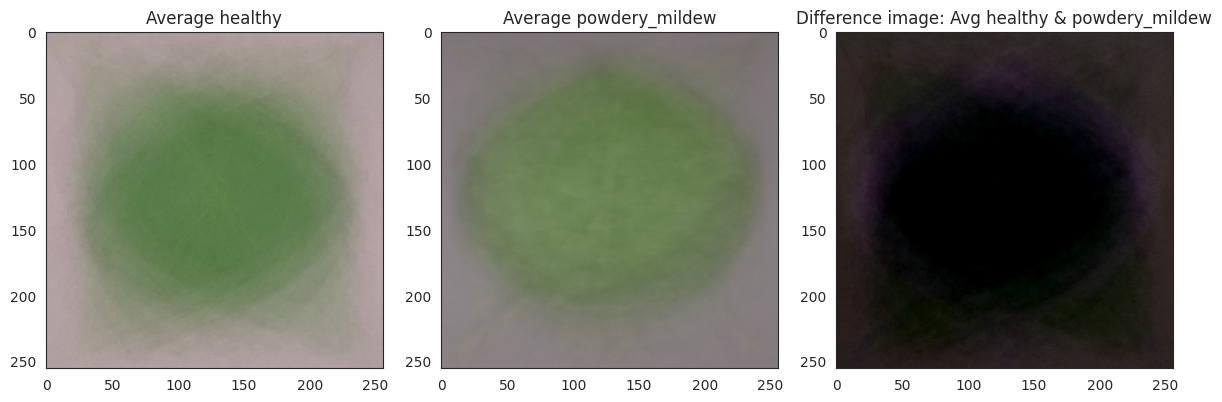

In [18]:
difference = diff_bet_avg_image_labels_data_as_array(
    X=images_arr,
    y=labels_arr,
    label_1="healthy",
    label_2="powdery_mildew",
    figsize=(12, 10),
)

A small difference can be seen of the leaves, Thats way this plit will be saved.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


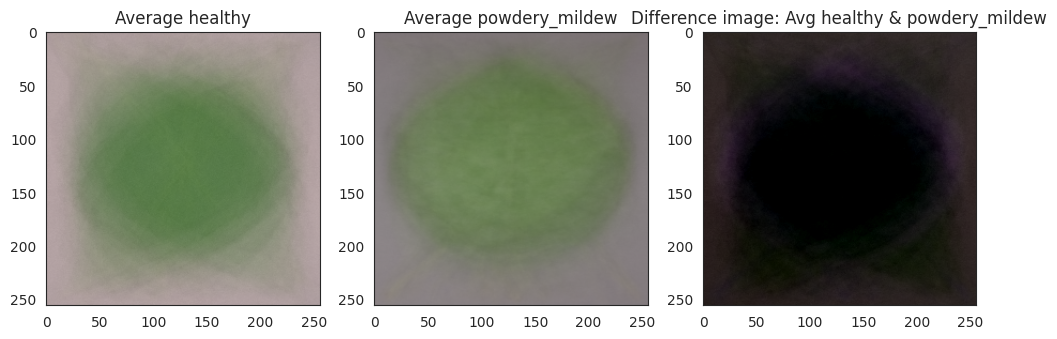

In [19]:
difference = diff_bet_avg_image_labels_data_as_array(
    X=images_arr,
    y=labels_arr,
    label_1="healthy",
    label_2="powdery_mildew",
    figsize=(12, 10),
    save_image=True
)

---


### Investigate variability within each images.

Leaves with powdery mildew have white spots on their surface. And will have a greater variability with the pixels, here we will investigate that.

#### Variability in grayscale-converted images.
Convert images to grayscale.

In [20]:
images_arr.shape

(200, 256, 256, 3)

In [21]:
images_gray_list = []
for img in images_arr:
    images_gray_list.append(np.dot(img[..., :], [0.2125, 0.7154, 0.0721]))

images_gray_arr = np.array(images_gray_list)
images_gray_arr.shape 

(200, 256, 256)

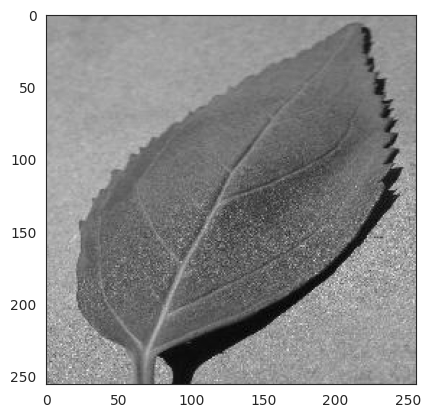

In [22]:
plt.imshow(images_gray_arr[0], cmap="gray")
plt.show()

For each label, display the disttribution of variability.

In [23]:
def plot_image_pixel_distribution_per_label(X, y, figsize=(12, 5), save_image=False):
    """
    Function pseudo-logic:
    - subset the images from each label
    - flatten each image to get an array of all pixels (3d -> 2d arr)
    - calculate the standard deviation of the pixels in each image (2d -> 1d arr)
    - output the average standard deviation of all images
    - display boxplot and histogram of the standard deviations
    """
    for label_to_display in np.unique(y):
        sns.set_style("white")

        arr = subset_label(label_to_display, X, y)

        arr = arr.reshape(arr.shape[0], -1)

        std_arr = np.std(arr, axis=1)

        print(f"==== Label {label_to_display} ====")

        print("std_arr shape:", std_arr.shape)
        print("Average variability:", np.mean(std_arr))

        fig, (ax_box, ax_hist) = plt.subplots(
            2, sharex=True, gridspec_kw={"height_ratios": (0.15, 0.85)}
        )

        sns.boxplot(x=std_arr, ax=ax_box)
        sns.histplot(x=std_arr, kde=True, ax=ax_hist)

        if save_image:
            plt.savefig(
                f"{file_path}/grayscale_pixel_variability_{label_to_display}.png",
                bbox_inches="tight",
                dpi=150,
            )
        else:
            plt.tight_layout()
            plt.show()

==== Label healthy ====
std_arr shape: (100,)
Average variability: 0.139441604324309


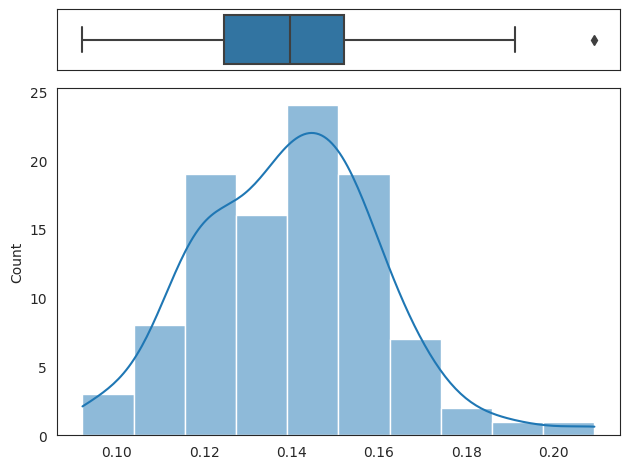

==== Label powdery_mildew ====
std_arr shape: (100,)
Average variability: 0.12223622262335782


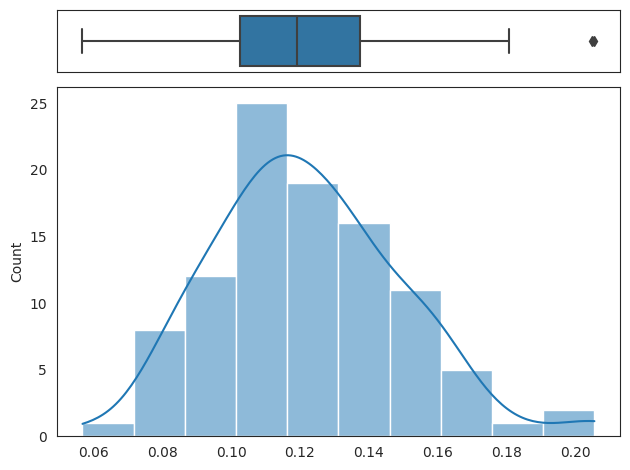

In [24]:
plot_image_pixel_distribution_per_label(images_gray_arr, labels_arr)

### __Conclusion:__
* The healthy leaf images have a slightly higher variability in their pixel values than the powdery mildew leaves.
* The analysis will be repeated on the original sample of images before color conversion, and the variability distribution within each color channel will be investigated.

### Variability per RBG

In [25]:
def plot_image_pixel_distribution_per_rgb_per_label(X, y, figsize=(12, 5), save_image=False, save_name="rgb_pixel_var"):
    for label_to_display in np.unique(y):
        sns.set_style("white")

        arr = subset_label(label_to_display, X, y)

        arr = arr.reshape(arr.shape[0], -1, arr.shape[3])

        std_arr = np.std(arr, axis=1)

        print(f"==== Label {label_to_display} ====")

        print("std_arr shape", std_arr.shape)  
        
        print("Red avg std:", np.mean(std_arr[:, 0]))
        print("Green avg std:", np.mean(std_arr[:, 1]))
        print("Blue avg std:", np.mean(std_arr[:, 2]))

        sns.histplot(std_arr, kde=True, palette=["red", "green", "blue"], legend=False)
        plt.title(f"Pixel variability distributions for label {label_to_display}")
        plt.xlabel("Variability of pixel values per RGB channel per image")

        if save_image:
            plt.savefig(
                f"{file_path}/{save_name}_{label_to_display}.png",
                bbox_inches="tight",
                dpi=150,
            )
            plt.clf()
        else:
            plt.tight_layout()
            plt.show()

==== Label healthy ====
std_arr shape (100, 3)
Red avg std: 0.19826190158438783
Green avg std: 0.12026094803299696
Blue avg std: 0.1985351613902673


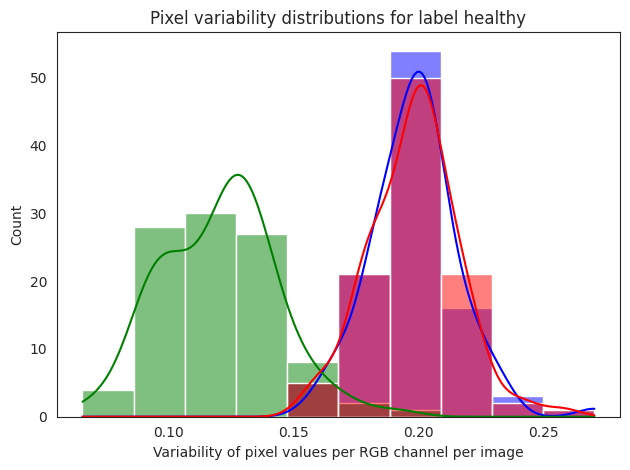

==== Label powdery_mildew ====
std_arr shape (100, 3)
Red avg std: 0.1356447364587147
Green avg std: 0.12103153682375709
Blue avg std: 0.1578664470191823


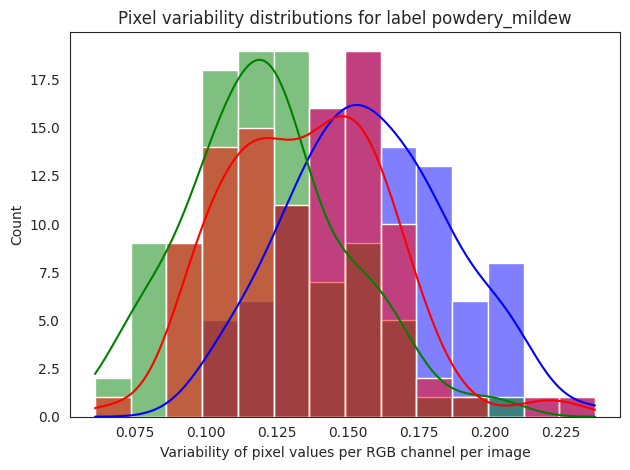

In [26]:
plot_image_pixel_distribution_per_rgb_per_label(images_arr, labels_arr)

In [27]:
def create_table_image_pixel_distribution_per_rgb_per_label(X, y):
    rgb_variability_df = pd.DataFrame(index=["red", "green", "blue"])

    for label_to_display in np.unique(y):
        arr = subset_label(label_to_display, X, y)

        # flatten each image array
        arr = arr.reshape(arr.shape[0], -1, arr.shape[3])

        std_arr = np.std(arr, axis=1)

        rgb_stds = []

        for i in range(3):
            rgb_stds.append(np.mean(std_arr[:, i]))
        
        rgb_variability_df[label_to_display] = rgb_stds
    
    return rgb_variability_df

In [28]:
rgb_variability_df = create_table_image_pixel_distribution_per_rgb_per_label(images_arr, labels_arr)
rgb_variability_df

healthy  powdery_mildew
red    0.198262        0.135645
green  0.120261        0.121032
blue   0.198535        0.157866

Saves plot and values.

In [29]:
plot_image_pixel_distribution_per_rgb_per_label(images_arr, labels_arr, save_image=True)

==== Label healthy ====
std_arr shape (100, 3)
Red avg std: 0.19826190158438783
Green avg std: 0.12026094803299696
Blue avg std: 0.1985351613902673
==== Label powdery_mildew ====
std_arr shape (100, 3)
Red avg std: 0.1356447364587147
Green avg std: 0.12103153682375709
Blue avg std: 0.1578664470191823


<Figure size 640x480 with 0 Axes>

In [30]:
joblib.dump(value=rgb_variability_df, filename=f"{file_path}/rgb_pixel_var_avgs.pkl")

['outputs/v1/rgb_pixel_var_avgs.pkl']

### Variability in every images.

In [31]:
images_arr.shape

(200, 256, 256, 3)

In [32]:
images_centeral_third_arr = images_arr[:, 88:166, 88:168, :]
images_centeral_third_arr.shape

(200, 78, 80, 3)

==== Label healthy ====
std_arr shape (100, 3)
Red avg std: 0.07419622665825577
Green avg std: 0.06948559509385382
Blue avg std: 0.07425222824427082


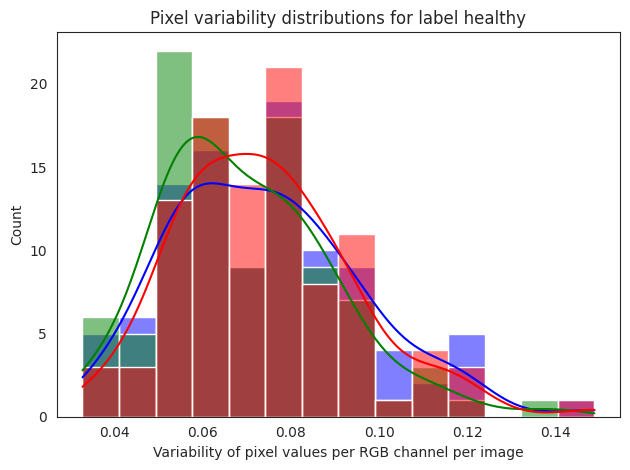

==== Label powdery_mildew ====
std_arr shape (100, 3)
Red avg std: 0.10135650427178289
Green avg std: 0.08969713461880671
Blue avg std: 0.1103090481244066


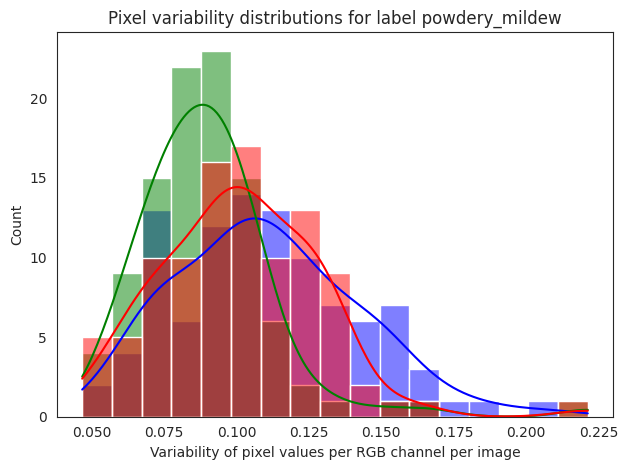

In [33]:
plot_image_pixel_distribution_per_rgb_per_label(images_centeral_third_arr, labels_arr)

Save images

In [34]:
def create_table_image_pixel_distribution_per_rgb_per_label(images, labels, save_fig=False, save_name=None):
    
    if save_fig:
        plt.savefig(save_name)
    

In [35]:
rgb_variability_df = create_table_image_pixel_distribution_per_rgb_per_label(images_centeral_third_arr, labels_arr, save_fig=True, save_name="rgb_pixel_var_center")

<Figure size 640x480 with 0 Axes>

In [36]:
joblib.dump(value=rgb_variability_df, filename=f"{file_path}/rbg_pixel_var_avgs_center.pkl")

['outputs/v1/rbg_pixel_var_avgs_center.pk1']

---


## Conclusions and next step